In [1]:
from PIL import Image
import os
import numpy as np
from string import digits
import pandas as pd
import matplotlib.pyplot as plt
from DataProcessor import DataProcessor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split

In [2]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()

# Mean Image

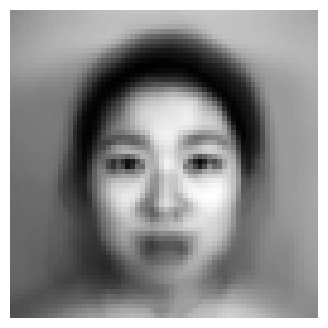

In [3]:
image_processor.calculate_mean_image()

# Demean and Original Images per each class

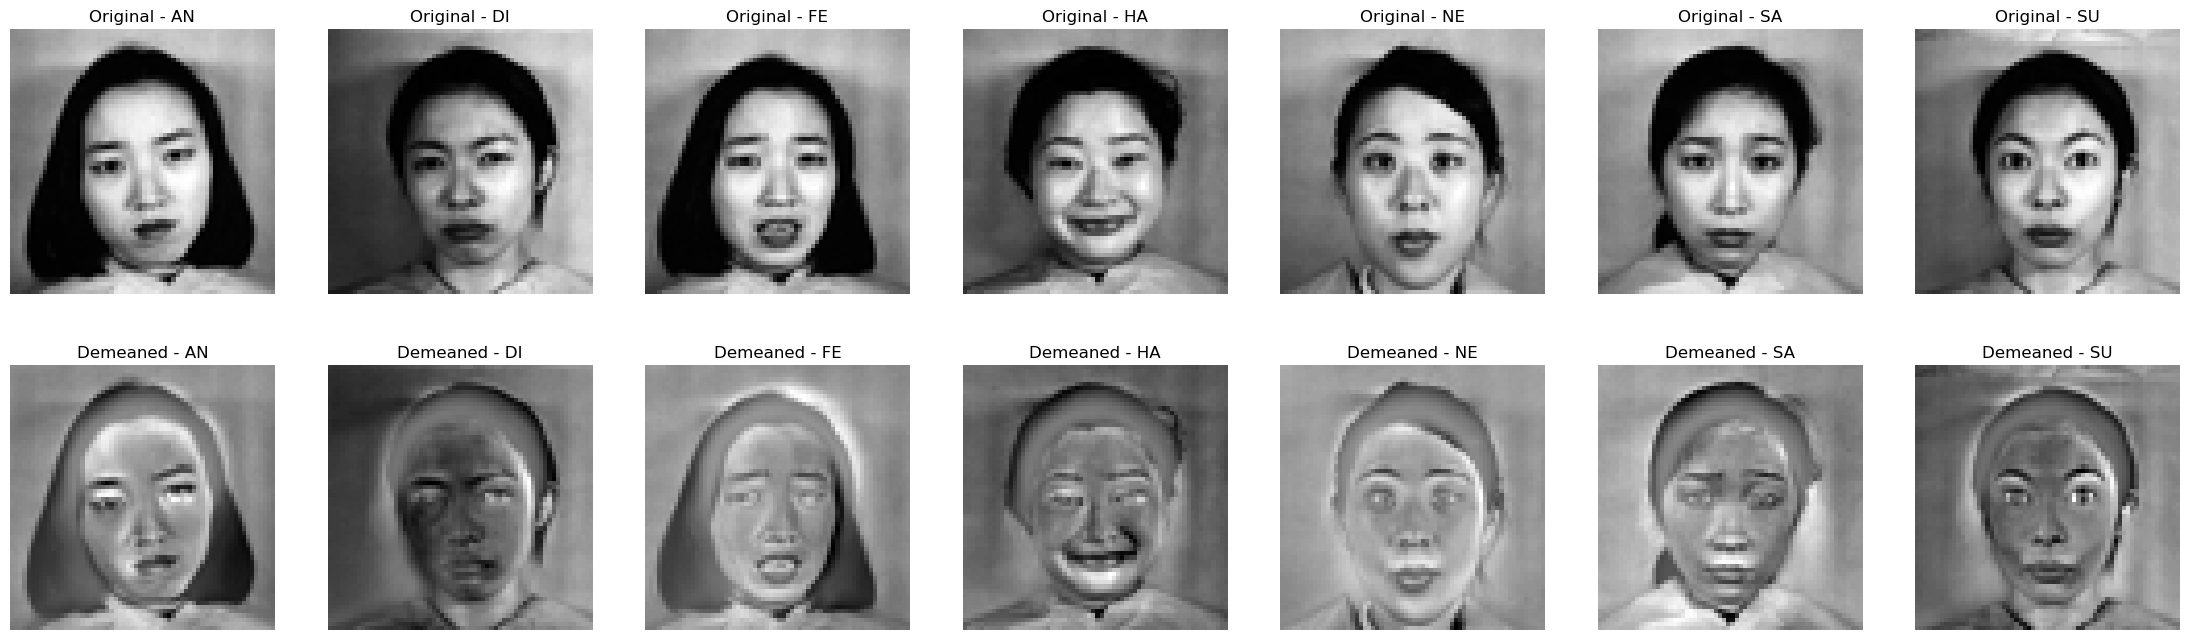

In [4]:
image_processor.demean_images()
image_processor.visualize_selected_images()

In [5]:
dataset = image_processor.data

In [6]:
#find mean of values of each variables
# calculate cov matrix
# Eigen value
# det(cov - lambdaI) = 0 
# Eigen vector
# Normalized eigen vector

1. **Contrast Adjustment**: The raw eigenfaces might not span the full range of grayscale values (0-255), which can make them appear too dark or too light. Normalization adjusts the contrast, making the features of the eigenface more visible.

In [7]:
img_matrix = np.array(dataset['Normalized_Image'].to_list())
cov_matrix = np.matmul(img_matrix.T, img_matrix) / img_matrix.shape[0]
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigen_values)[::-1]
sorted_eigenvectors = eigen_vectors[:, sorted_indices]

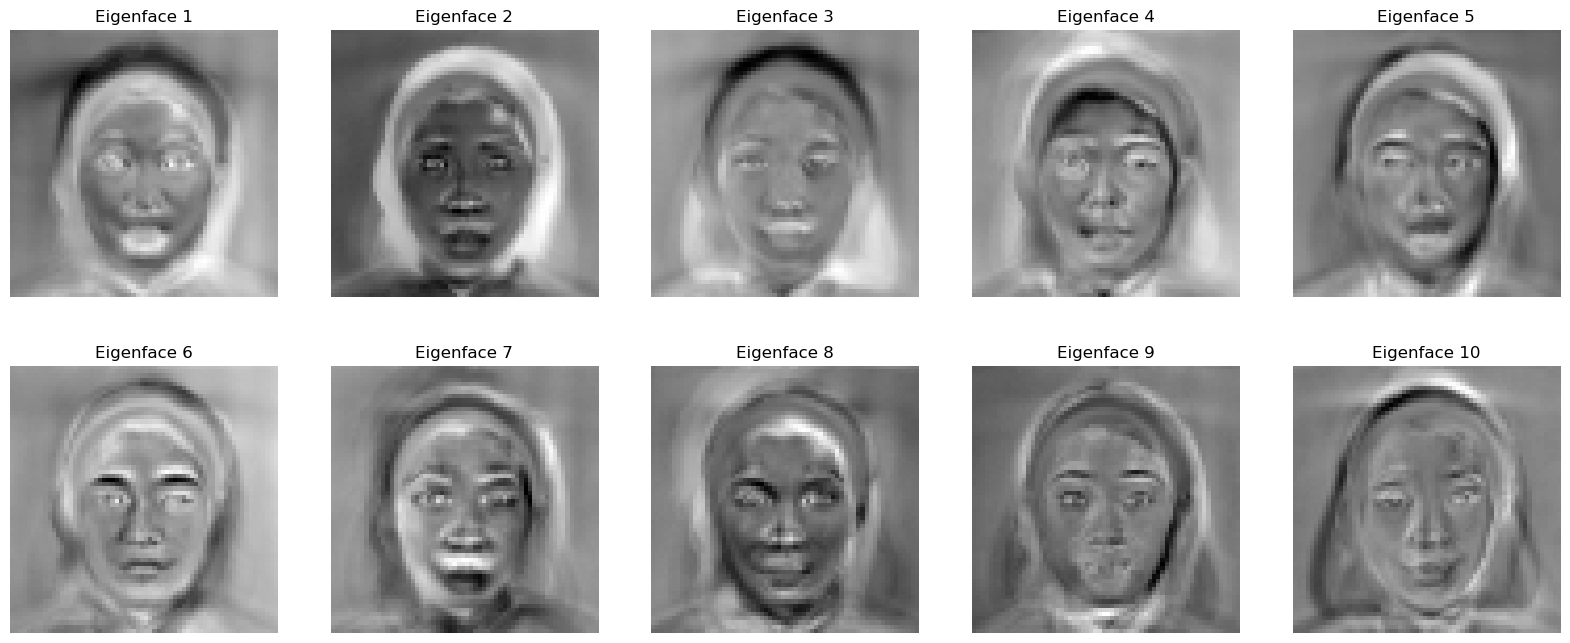

In [8]:
num_eigenfaces = 10
num_plots_per_row = 5
num_rows = int(np.ceil(num_eigenfaces / num_plots_per_row))

plt.figure(figsize=(20, 4 * num_rows))

for i in range(num_eigenfaces):
    # i-th column
    eigen_face = sorted_eigenvectors[:, i]
    eigen_face = (eigen_face - eigen_face.min()) / (eigen_face.max() - eigen_face.min())
    eigen_img = eigen_face.reshape((64, 64))
    plt.subplot(num_rows, num_plots_per_row, i % num_plots_per_row + 1 + (i // num_plots_per_row) * num_plots_per_row)
    plt.imshow(eigen_img, cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')
plt.show()

In [9]:
labels = dataset['Expression']
unique_labels = list(set(labels))
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta']
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

In [10]:
def plot_projection(dimensions):
    top_eigenfaces = sorted_eigenvectors[:, :dimensions]
    projected_data = np.dot(img_matrix, top_eigenfaces)

    fig = plt.figure(figsize=(8, 6))

    if dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')
        for label in unique_labels:
            indices = [i for i, l in enumerate(labels) if l == label]
            ax.scatter(projected_data[indices, 0], projected_data[indices, 1], projected_data[indices, 2], 
                       c=label_color_map[label], label=label)
    else:
        ax = fig.add_subplot(111)
        for label in unique_labels:
            indices = [i for i, l in enumerate(labels) if l == label]
            ax.scatter(projected_data[indices, 0], projected_data[indices, 1], 
                       c=label_color_map[label], label=label)

    plt.title(f'{dimensions}D Projection using Eigenfaces')
    plt.legend()
    plt.show()

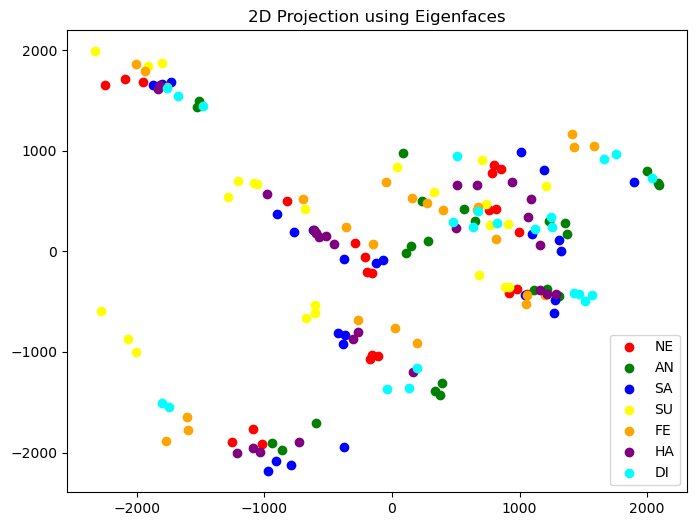

In [11]:
plot_projection(2)

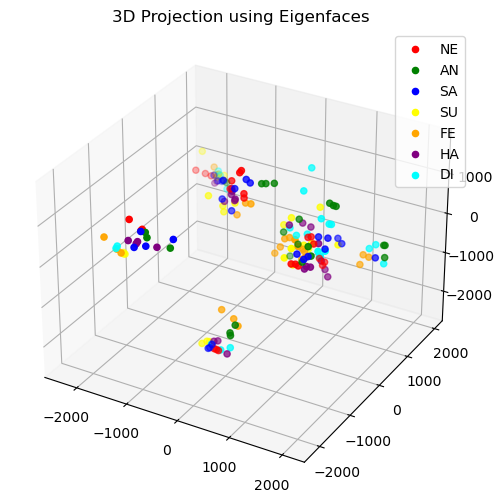

In [12]:
plot_projection(3)

In [13]:
def reconstruct_faces(projected_data, eigenfaces, mean_face):
    reconstructed = np.dot(projected_data, eigenfaces.T) + mean_face
    return reconstructed

In [14]:
mean_face = image_processor.mean_image
dimensions = 10
top_eigenfaces = sorted_eigenvectors[:, :dimensions]
projected_data = np.dot(img_matrix, top_eigenfaces)

reconstructed_faces = reconstruct_faces(projected_data, top_eigenfaces, mean_face)

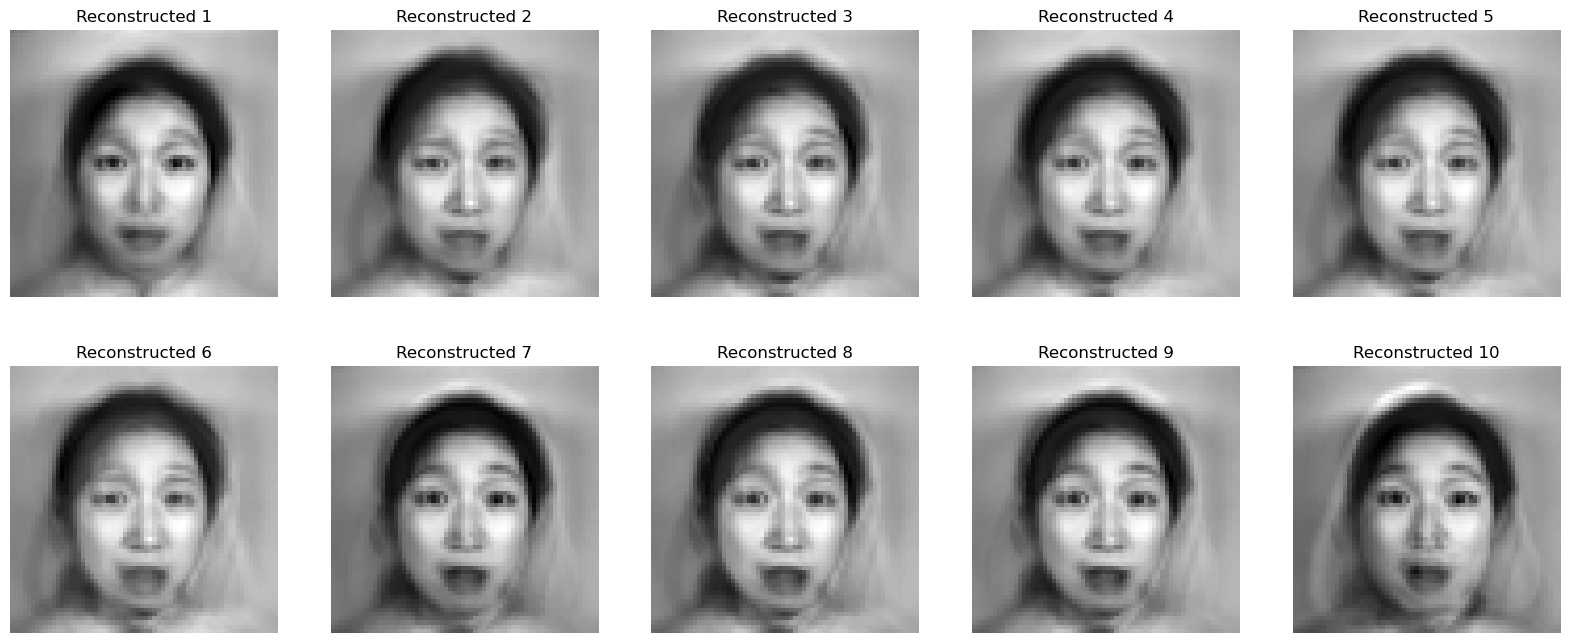

In [15]:
# You can visualize the reconstructed faces similar to how you visualized the eigenfaces
plt.figure(figsize=(20, 4 * num_rows))
for i in range(num_eigenfaces):
    face_img = reconstructed_faces[i].reshape((64, 64))
    face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())  # Normalize for display
    plt.subplot(num_rows, num_plots_per_row, i % num_plots_per_row + 1 + (i // num_plots_per_row) * num_plots_per_row)
    plt.imshow(face_img, cmap='gray')
    plt.title(f'Reconstructed {i + 1}')
    plt.axis('off')
plt.show()

In [16]:
random_image_indices = {}
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    random_index = random.choice(indices)
    random_image_indices[label] = random_index

In [17]:
original_image = np.array(dataset['Image'].to_list())

In [18]:
selected_images = original_image[[random_image_indices[label] for label in unique_labels]]
selected_projected = np.dot(selected_images, top_eigenfaces)
selected_reconstructed = reconstruct_faces(selected_projected, top_eigenfaces, mean_face)

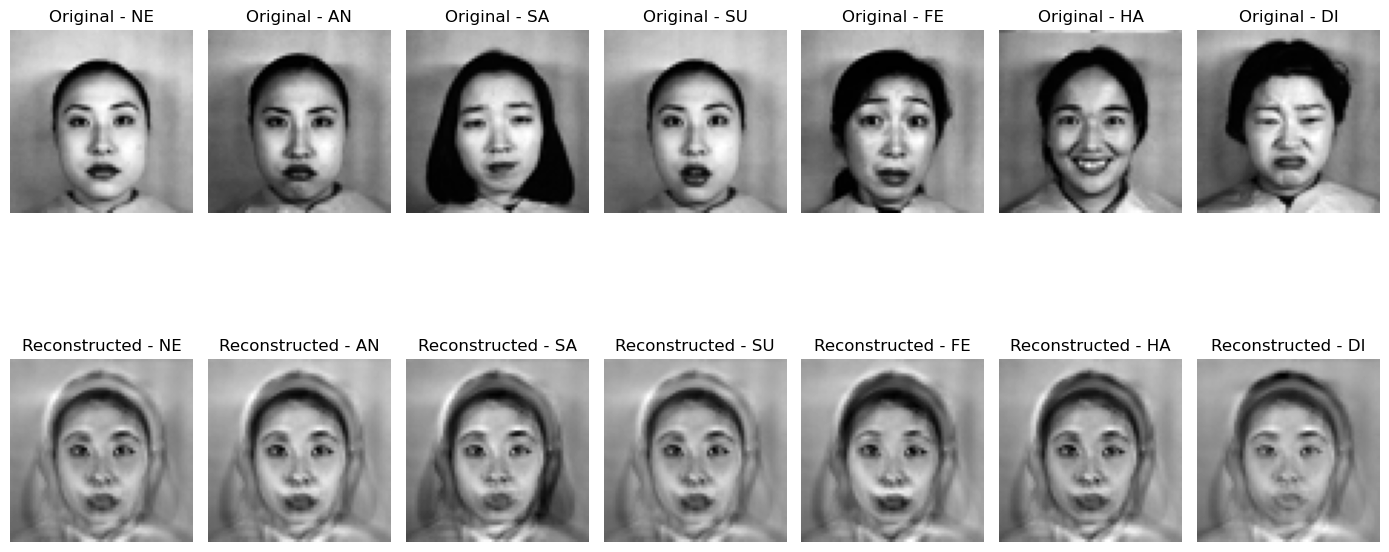

In [19]:
num_classes = len(unique_labels)
plt.figure(figsize=(2 * num_classes, 8))

for i, label in enumerate(unique_labels):
    original_img = selected_images[i].reshape((64, 64))
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())  # Normalize
    plt.subplot(2, num_classes, i + 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original - {label}')
    plt.axis('off')

    reconstructed_img = selected_reconstructed[i].reshape((64, 64))
    reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min())  # Normalize
    plt.subplot(2, num_classes, i + num_classes + 1)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'Reconstructed - {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


To determine the number of principal components (PCs) needed to retain 90% of the cumulative variance in your data, you need to follow these steps:

Calculate the Cumulative Explained Variance
Find the Minimum Number of PCs to Reach 90% of Cumulative Variance

In [20]:
total_variance = sum(eigen_values)
cumulative_variance = 0
num_components_for_90_percent = 0

for eigen_value in sorted(eigen_values, reverse=True):
    cumulative_variance += eigen_value
    num_components_for_90_percent += 1
    if cumulative_variance / total_variance >= 0.9:
        break

print(f"Number of principal components to retain 90% of the variance: {num_components_for_90_percent}")


Number of principal components to retain 90% of the variance: 25


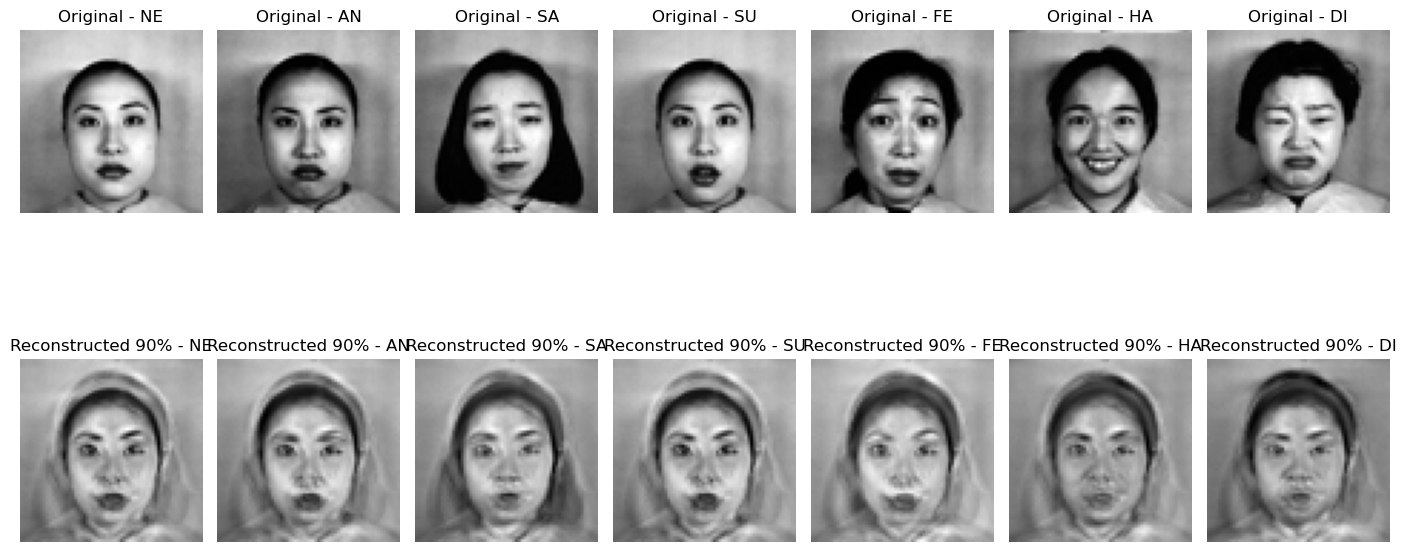

In [21]:
top_eigenfaces_for_90_percent = sorted_eigenvectors[:, :num_components_for_90_percent]
selected_projected_90 = np.dot(selected_images, top_eigenfaces_for_90_percent)
selected_reconstructed_90 = reconstruct_faces(selected_projected_90, top_eigenfaces_for_90_percent, mean_face)

plt.figure(figsize=(2 * num_classes, 8))

for i, label in enumerate(unique_labels):
    original_img = selected_images[i].reshape((64, 64))
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())  # Normalize
    plt.subplot(2, num_classes, i + 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original - {label}')
    plt.axis('off')

    # Reconstructed Image (90% Variance)
    reconstructed_img_90 = selected_reconstructed_90[i].reshape((64, 64))
    reconstructed_img_90 = (reconstructed_img_90 - reconstructed_img_90.min()) / (reconstructed_img_90.max() - reconstructed_img_90.min())  # Normalize
    plt.subplot(2, num_classes, i + num_classes + 1)
    plt.imshow(reconstructed_img_90, cmap='gray')
    plt.title(f'Reconstructed 90% - {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
from Metrics import Metrics
from Model import QuadraticDiscriminantAnalysis

In [23]:
projected_data_for_90_percent = np.dot(img_matrix, top_eigenfaces_for_90_percent)
X_train, X_test, y_train, y_test = train_test_split(projected_data_for_90_percent, labels, test_size=0.3, random_state=42)

In [24]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict_likelihood(X_test)

In [ ]:
train_accuracies = []
test_accuracies = []

for n_components in range(1, len(sorted_eigenvectors) + 1):
    top_eigenfaces_n = sorted_eigenvectors[:, :n_components]
    projected_data_n = np.dot(img_matrix, top_eigenfaces_n)

    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(projected_data_n, labels, test_size=0.3, random_state=42)

    qda_n = QuadraticDiscriminantAnalysis()
    qda_n.fit(X_train_n, y_train_n)
    y_pred_train = qda_n.predict(X_train_n)
    y_pred_test = qda_n.predict(X_test_n)

    train_accuracy = accuracy_score(y_train_n, y_pred_train)
    test_accuracy = accuracy_score(y_test_n, y_pred_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_eigenvectors) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(sorted_eigenvectors) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Effect of Number of PCs on QDA Classifier Accuracy')
plt.legend()
plt.show()